In [303]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


Os dados começaram a obter um índice adequado de preenchimento a partir de 2020. Portanto, vamos desconsiderar os anos anteriores para este projeto.

In [304]:
# Caminho para o diretório onde estão os datasets
diretorio = 'data/raw/'

# Lista para armazenar cada DataFrame
dataframes = []

# Loop através dos anos dos datasets
for ano in range(2020, 2024):
    arquivo = os.path.join(diretorio, f'acidentes_{ano}.csv')
    if os.path.exists(arquivo):
        df = pd.read_csv(arquivo, delimiter = ';')
        dataframes.append(df)
    else:
        print(f"Não foi possível encontrar o arquivo de nome: {arquivo}")

# Concatenar todos os DataFrames em um só
df_acidentes = pd.concat(dataframes, ignore_index=True)


In [305]:
df_acidentes.head(2)

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,bairro_cruzamento,num_semaforo,sentido_via,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,acidente_verificado,tempo_clima,situacao_semaforo,sinalizacao,condicao_via,conservacao_via,ponto_controle,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,Protocolo,natureza
0,2020-01-01,00:39:00,SEM VÍTIMA,CANCELADA,ÁGUA FRIA,RUA SAO SEBASTIAO,1687,NaN,EM FRENTE A IGREJA UNIVERSAL,ÁGUA FRIA,NaN,NaN,COLISÃO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,01:04:00,SEM VÍTIMA,FINALIZADA,CORDEIRO,AV CAXANGA,1444,AV GENERAL SAN MARTIN,NaN,CORDEIRO,80.0,SUBURBIO,ABALROAMENTO LONGITUDINAL,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,NaN,60 km/h,Dupla,Canteiro central,NaN,NaN,NaN,NaN


# Tipagem de dados

In [306]:
df_acidentes.dtypes

data                         object
hora                         object
natureza_acidente            object
situacao                     object
bairro                       object
endereco                     object
numero                       object
detalhe_endereco_acidente    object
complemento                  object
bairro_cruzamento            object
num_semaforo                 object
sentido_via                  object
tipo                         object
descricao                    object
auto                         object
moto                         object
ciclom                       object
ciclista                     object
pedestre                     object
onibus                       object
caminhao                     object
viatura                      object
outros                       object
vitimas                      object
vitimasfatais                object
acidente_verificado          object
tempo_clima                  object
situacao_semaforo           

### O que podemos observar?

A tipagem não está bem definida, com quase todos os campos com tipo " object ". Podemos utilizar os metadados que obtivemos junto com o dataset para mapear e corrigir a tipagem. 


In [307]:
#tratando possíveis erros na tipagem dos dados a partir dos metadados existentes.

def ajustar_tipos(df, tipos):
    for coluna, tipo in tipos.items():
        if coluna in df.columns:
            if tipo == 'datetime64':
                df[coluna] = pd.to_datetime(df[coluna], errors='coerce')  # Converte para datetime, erro se falhar
            elif tipo == 'float64' or tipo == float:
                # Antes de converter para float, remove espaços, substitui vírgulas por pontos e trata erros
                df[coluna] = df[coluna].apply(lambda x: str(x).strip().replace(',', '.')).astype(float)
            #elif coluna == 'hora' and tipo == 'hora':
                # Convertendo a string de hora para tipo de hora pandas, manipulando erros
                #df[coluna] = pd.to_datetime(df[coluna], format='%H:%M:%S', errors='coerce').dt.time
            else:
                df[coluna] = df[coluna].astype(tipo)  # Aplica outros tipos conforme especificado


tipo_de_dados = {
    'tipo': str,
    'situacao': str,
    'data': 'datetime64',
    #'hora': 'hora',
    'bairro': str,
    'endereco': str,
    'complemento': str,
    'natureza': str,
    'descricao': str,
    'auto': float,
    'moto': float,
    'ciclom': float,
    'ciclista': float,
    'pedestre': float,
    'onibus': float,
    'caminhao': float,
    'viatura': float,
    'outros': float,
    'vitimas': float,
    'vitimasfatais': float
}

# Suponha que df_acidentes seja o DataFrame que você está utilizando
ajustar_tipos(df_acidentes, tipo_de_dados)


In [308]:
df_acidentes.dtypes

data                         datetime64[ns]
hora                                 object
natureza_acidente                    object
situacao                             object
bairro                               object
endereco                             object
numero                               object
detalhe_endereco_acidente            object
complemento                          object
bairro_cruzamento                    object
num_semaforo                         object
sentido_via                          object
tipo                                 object
descricao                            object
auto                                float64
moto                                float64
ciclom                              float64
ciclista                            float64
pedestre                            float64
onibus                              float64
caminhao                            float64
viatura                             float64
outros                          

In [309]:
df_acidentes.head()

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,bairro_cruzamento,num_semaforo,sentido_via,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,acidente_verificado,tempo_clima,situacao_semaforo,sinalizacao,condicao_via,conservacao_via,ponto_controle,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,Protocolo,natureza
0,2020-01-01,00:39:00,SEM VÍTIMA,CANCELADA,ÁGUA FRIA,RUA SAO SEBASTIAO,1687,NaN,EM FRENTE A IGREJA UNIVERSAL,ÁGUA FRIA,NaN,NaN,COLISÃO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,2020-01-01,01:04:00,SEM VÍTIMA,FINALIZADA,CORDEIRO,AV CAXANGA,1444,AV GENERAL SAN MARTIN,nan,CORDEIRO,80.0,SUBURBIO,ABALROAMENTO LONGITUDINAL,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,NaN,60 km/h,Dupla,Canteiro central,NaN,NaN,NaN,nan
2,2020-01-01,02:16:00,SEM VÍTIMA,FINALIZADA,AREIAS,AV RECIFE,NaN,NaN,LADO OPOSTO AO RESIDENCIAL IGNEZ ANDREAZZA,AREIAS,494.0,SUBURBIO,CHOQUE VEÍCULO PARADO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Longo da via,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,Não há placas,NaN,Dupla,Canteiro central,NaN,NaN,NaN,nan
3,2020-01-01,02:22:00,SEM VÍTIMA,FINALIZADA,BOA VIAGEM,AV BOA VIAGEM,NaN,NaN,EM FRENTE AO 1º JARDIM B. VIAGEM,BOA VIAGEM,NaN,CIDADE,COLISÃO TRASEIRA,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Longo da via,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,R-6a,NaN,Única,Faixa seccionada,NaN,NaN,NaN,nan
4,2020-01-01,03:33:00,SEM VÍTIMA,FINALIZADA,PAISSANDU,AV GOVERNADOR AGAMENON MAGALHAES,NaN,NaN,CAIXA ECONÔMICA FEDERAL ILHA DO LEITE,PAISSANDU,672.0,SUBURBIO,ABALROAMENTO TRANSVERSAL,COLISÃOENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,Não há placas,NaN,Única,Faixa contínua,Faixa seccionada,Canteiro central,NaN,nan


# Tratamento de Dados Ausentes

In [310]:
#analisando quantidades de nulos

nulos_por_coluna = df_acidentes.isnull().sum()
print(nulos_por_coluna)

data                           168
hora                          2837
natureza_acidente            34237
situacao                         0
bairro                           0
endereco                         0
numero                       24311
detalhe_endereco_acidente    30375
complemento                      0
bairro_cruzamento              148
num_semaforo                 37109
sentido_via                  33264
tipo                             0
descricao                        0
auto                           608
moto                          2400
ciclom                        4073
ciclista                      3940
pedestre                      3937
onibus                        3601
caminhao                      3797
viatura                       4020
outros                        4032
vitimas                         14
vitimasfatais                 4071
acidente_verificado          33541
tempo_clima                  33424
situacao_semaforo            33513
sinalizacao         

In [311]:
#Percentual de nulos

percentual_nulos = (df_acidentes.isnull().sum() / len(df_acidentes)) * 100
print(percentual_nulos)

data                          0.412695
hora                          6.969146
natureza_acidente            84.103862
situacao                      0.000000
bairro                        0.000000
endereco                      0.000000
numero                       59.720448
detalhe_endereco_acidente    74.616783
complemento                   0.000000
bairro_cruzamento             0.363565
num_semaforo                 91.158986
sentido_via                  81.713668
tipo                          0.000000
descricao                     0.000000
auto                          1.493564
moto                          5.895647
ciclom                       10.005404
ciclista                      9.678687
pedestre                      9.671318
onibus                        8.845927
caminhao                      9.327405
viatura                       9.875209
outros                        9.904687
vitimas                       0.034391
vitimasfatais                10.000491
acidente_verificado      

#### Preenchimento da coluna natureza_acidente

Note que a coluna de natureza_acidente possui um índice de nulos muito elevado, mas é possível realizar o preenchimento a partir das colunas que representam as vítimas e as vítimas fatais. Essa coluna categória é muito importante para as análises que realizaremos posteriormente.

In [312]:
def classificar_acidente(row):
    if row['vitimasfatais'] > 0:
        return 'Fatal'
    elif row['vitimas'] > 0:
        return 'Não fatal'
    else:
        return 'Sem vítimas'

df_acidentes['natureza_acidente'] = df_acidentes.apply(classificar_acidente, axis=1)

#### Remoção de colunas

É possível observar que o percentual de nulos em algumas colunas do dataframe é muito alto. Realizaremos um recorte das colunas que possuem quantidade de nulos maior que 25% para trabalharmos com dados mais consistentes.

In [313]:
# Removendo colunas com índice de nulos maior que 25%:

df_acidentes = df_acidentes.loc[:, df_acidentes.isnull().sum() / len(df_acidentes) < 0.25]


In [314]:
percentual_nulos = (df_acidentes.isnull().sum() / len(df_acidentes)) * 100
print(percentual_nulos)

data                  0.412695
hora                  6.969146
natureza_acidente     0.000000
situacao              0.000000
bairro                0.000000
endereco              0.000000
complemento           0.000000
bairro_cruzamento     0.363565
tipo                  0.000000
descricao             0.000000
auto                  1.493564
moto                  5.895647
ciclom               10.005404
ciclista              9.678687
pedestre              9.671318
onibus                8.845927
caminhao              9.327405
viatura               9.875209
outros                9.904687
vitimas               0.034391
vitimasfatais        10.000491
Protocolo            15.901051
natureza              0.000000
dtype: float64


In [315]:
#aproveitamos esse momento para remover a coluna "natureza", que não possui utilidade para nós.

df_acidentes = df_acidentes.drop('natureza', axis=1)


# Normalização e Discretização

In [316]:
# Selecionando apenas colunas
numeric_cols = df_acidentes.select_dtypes(include=['int64', 'float64']).columns


df_acidentes_clean = df_acidentes.dropna(subset=numeric_cols)

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Ajustando e transformando os dados
discretized_data = discretizer.fit_transform(df_acidentes_clean[numeric_cols])
df = pd.DataFrame(discretized_data, columns=[col + '_bin' for col in numeric_cols])
df_acidentes = pd.concat([df_acidentes_clean.reset_index(drop=True), df], axis=1)
#Removendo colunas originais após discretização:
df_acidentes = df_acidentes.drop(columns=numeric_cols)

# Normalização
scaler = MinMaxScaler()
numeric_cols = df_acidentes.select_dtypes(include=['int64', 'float64']).columns
df_acidentes[numeric_cols] = scaler.fit_transform(df_acidentes[numeric_cols])




# Limpeza de dados

### Análise de duplicatas

In [317]:
duplicatas = df_acidentes.duplicated(keep=False)

numero_duplicatas = duplicatas.sum()

# Mostrar o número de duplicatas
print(f'Número de registros duplicados existentes: {numero_duplicatas}')



Número de registros duplicados existentes: 2


In [318]:
df_acidentes[duplicatas].head(10)

,data,hora,natureza_acidente,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,Protocolo,auto_bin,moto_bin,ciclom_bin,ciclista_bin,pedestre_bin,onibus_bin,caminhao_bin,viatura_bin,outros_bin,vitimas_bin,vitimasfatais_bin
612,2021-04-10,16:36:00,Sem vítimas,FINALIZADA,DERBY,AV GOVERNADOR AGAMENON MAGALHAES,nan,DERBY,SEMÁFORO,nan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
613,2021-04-10,16:36:00,Sem vítimas,FINALIZADA,DERBY,AV GOVERNADOR AGAMENON MAGALHAES,nan,DERBY,SEMÁFORO,nan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [319]:
df_acidentes = df_acidentes.drop_duplicates()

In [320]:
df_acidentes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36615 entries, 0 to 36615
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               36447 non-null  datetime64[ns]
 1   hora               33778 non-null  object        
 2   natureza_acidente  36615 non-null  object        
 3   situacao           36615 non-null  object        
 4   bairro             36615 non-null  object        
 5   endereco           36615 non-null  object        
 6   complemento        36615 non-null  object        
 7   bairro_cruzamento  36502 non-null  object        
 8   tipo               36615 non-null  object        
 9   descricao          36615 non-null  object        
 10  Protocolo          34235 non-null  object        
 11  auto_bin           36615 non-null  float64       
 12  moto_bin           36615 non-null  float64       
 13  ciclom_bin         36615 non-null  float64       
 14  ciclista_bi

# Análise de dados

moto_bin - Outliers identificados: 498
Limite Inferior para moto_bin: 0.0, Limite Superior para moto_bin: 0.0
auto_bin - Outliers identificados: 1201
Limite Inferior para auto_bin: 0.0, Limite Superior para auto_bin: 0.0
vitimas_bin - Outliers identificados: 9
Limite Inferior para vitimas_bin: 0.0, Limite Superior para vitimas_bin: 0.0


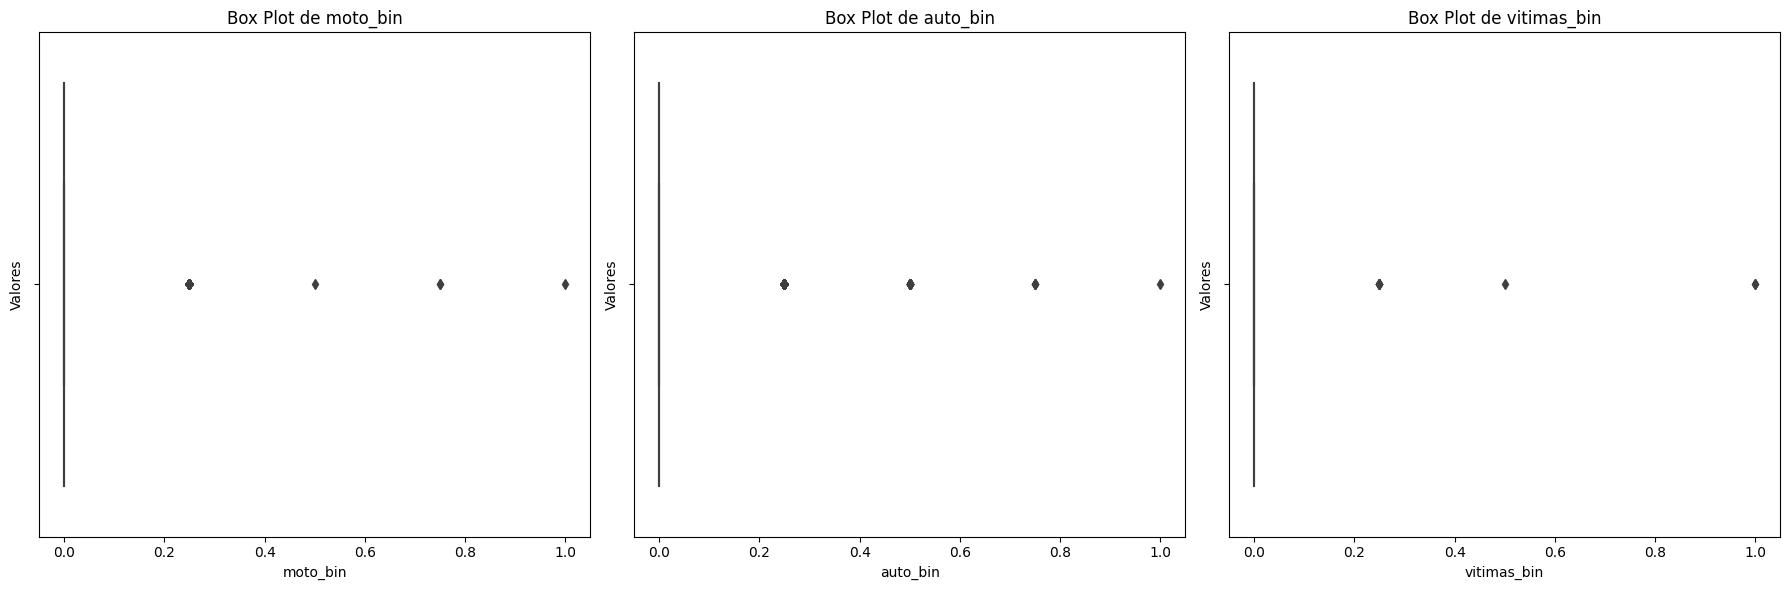

In [321]:
# Lista das variáveis mais importantes
important_vars = ['moto_bin', 'auto_bin', 'vitimas_bin']

fig, axes = plt.subplots(nrows=1, ncols=len(important_vars), figsize=(18, 6))

# Loop pelas variáveis importantes para aplicar o método de Tukey
for i, var in enumerate(important_vars):
    Q1 = df_acidentes[var].quantile(0.25)
    Q3 = df_acidentes[var].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definindo os limites para considerar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificando os outliers
    outliers = df_acidentes[(df_acidentes[var] < lower_bound) | (df_acidentes[var] > upper_bound)]
    
    print(f"{var} - Outliers identificados: {len(outliers)}")
    print(f"Limite Inferior para {var}: {lower_bound}, Limite Superior para {var}: {upper_bound}")

    # Plotando box plot para cada variável
    sns.boxplot(x=df_acidentes[var], ax=axes[i])
    axes[i].set_title(f'Box Plot de {var}')
    axes[i].set_xlabel(f'{var}')
    axes[i].set_ylabel('Valores')

# Ajustar layout
plt.tight_layout()
plt.show()


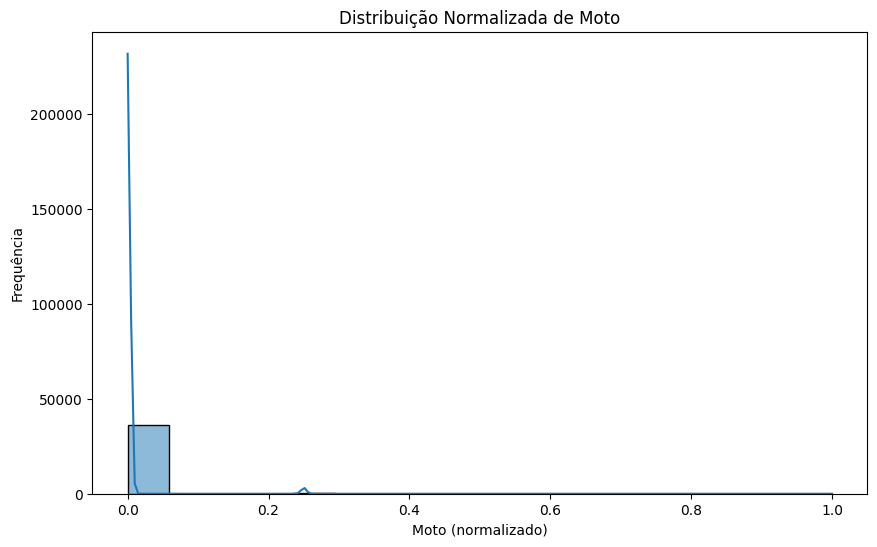

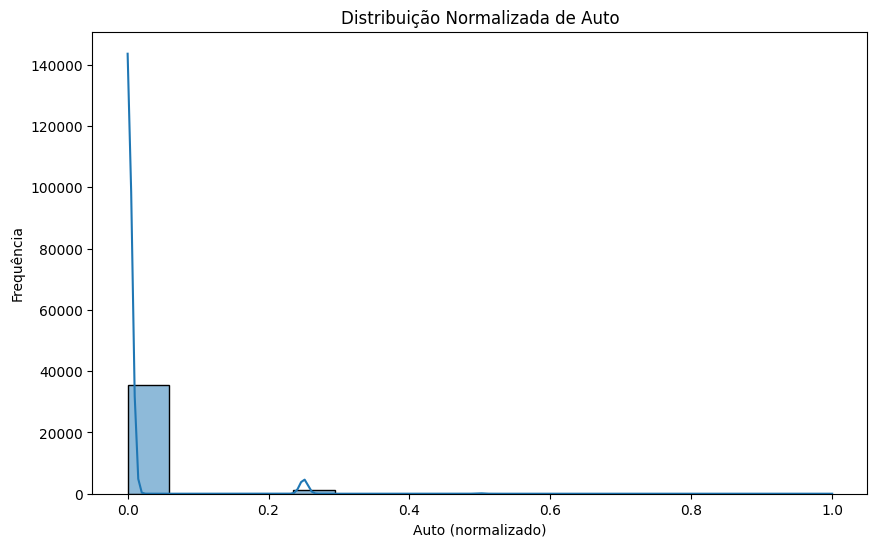

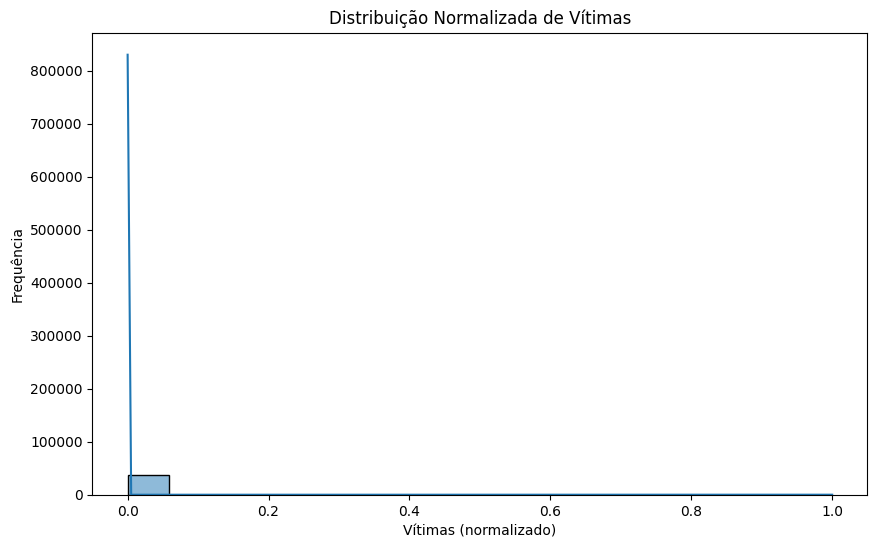

In [322]:


# Histograma para a variável 'moto'
plt.figure(figsize=(10, 6))
sns.histplot(df_acidentes['moto_bin'], kde=True)
plt.title('Distribuição Normalizada de Moto')
plt.xlabel('Moto (normalizado)')
plt.ylabel('Frequência')
plt.show()

# Histograma para a variável 'auto'
plt.figure(figsize=(10, 6))
sns.histplot(df_acidentes['auto_bin'], kde=True)
plt.title('Distribuição Normalizada de Auto')
plt.xlabel('Auto (normalizado)')
plt.ylabel('Frequência')
plt.show()

# Histograma para a variável 'vitimas'
plt.figure(figsize=(10, 6))
sns.histplot(df_acidentes['vitimas_bin'], kde=True)
plt.title('Distribuição Normalizada de Vítimas')
plt.xlabel('Vítimas (normalizado)')
plt.ylabel('Frequência')
plt.show()


<Axes: >

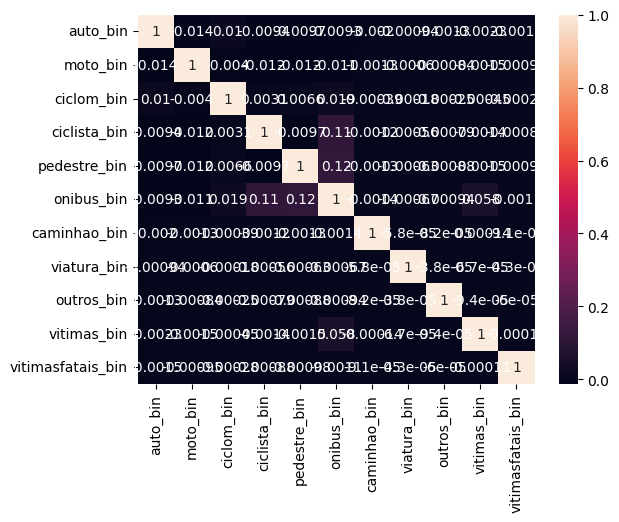

In [323]:
# Análise Bivariada
# Correlação entre variáveis

df_numeric = df_acidentes.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True)

Vítimas e Moto: Existe uma correlação relativamente forte (aproximadamente 0.71) entre motocicletas (moto) e vítimas não fatais (vitimas). Isso indica que acidentes envolvendo motocicletas têm uma tendência maior de resultar em vítimas não fatais.



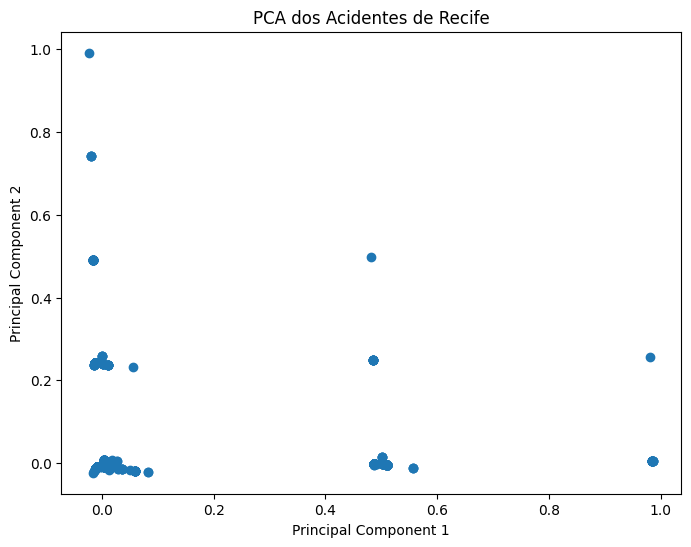

Explained variance by Principal Component 1: 0.4079819760569119
Explained variance by Principal Component 2: 0.1979056307307009


In [324]:


# Selecionando apenas as colunas numéricas para PCA
numeric_cols = df_acidentes.select_dtypes(include=['int64', 'float64']).columns
df_numeric = df_acidentes[numeric_cols].dropna()

# Aplicando PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_numeric)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

plt.figure(figsize=(8,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA dos Acidentes de Recife')
plt.show()

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by Principal Component 1: {explained_variance[0]}")
print(f"Explained variance by Principal Component 2: {explained_variance[1]}")

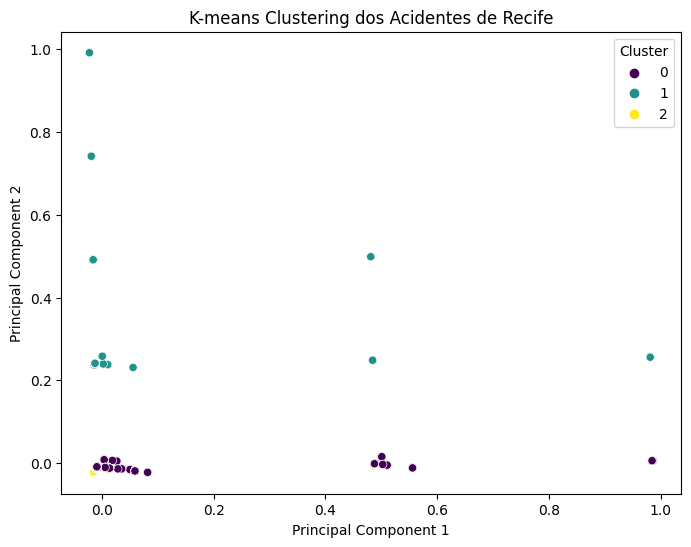

In [325]:
# Aplicar K-means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_numeric)

df_pca['Cluster'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=df_pca)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering dos Acidentes de Recife')
plt.legend(title='Cluster')
plt.show()

# Enriquecimento de Dados

Essa é uma etapa extra, mas acredito que seja interessante enriquecer nosso dataset ao adicionarmos informações que podem ser inferidas. O objetivo é facilitar possíveis filtros e agregações de dados.

In [328]:
# Enriquecimento envolvendo características de data e hora. 

def get_season(month):
    if month in [12, 1, 2]:
        return 'Verão'
    elif month in [3, 4, 5]:
        return 'Outono'
    elif month in [6, 7, 8]:
        return 'Inverno'
    elif month in [9, 10, 11]:
        return 'Primavera'




df_acidentes['dia_da_semana'] = df_acidentes['data'].dt.day_name()
df_acidentes['mes'] = df_acidentes['data'].dt.month
df_acidentes['ano'] = df_acidentes['data'].dt.year
df_acidentes['estacao'] = df_acidentes['data'].dt.month.apply(get_season)

# Exportação do dataset refinado.

In [329]:
nome_arquivo = 'acidentes_recife'
df_acidentes.to_csv(f'data/refined/{nome_arquivo}.csv', sep = ',')